In [1]:
#import packages to do EDA
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os
%matplotlib inline
plt.style.use('fivethirtyeight')
import gc

# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable
import matplotlib.font_manager


from sklearn.model_selection import train_test_split
from tqdm import tqdm

import lightgbm as lgb
import pickle


#reference:https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix,roc_curve, auc
from sklearn.metrics import log_loss
import optuna
import warnings
warnings.filterwarnings('ignore')

#### Read vector from pickle file

In [2]:
with open('./data/train_vector_2.pkl', 'rb') as f:
    X = pickle.load(f)

In [3]:
with open('./data/feature_names_2.pkl', 'rb') as f:
    feature_names = pickle.load(f)

In [4]:
print(X.shape[1],len(feature_names))

1379 1379


In [5]:
with open('./data/yvalues_2.pkl', 'rb') as f:
    y = pickle.load(f)

# testing purpose only
traindata=50000
X = X.toarray()[:traindata,:]
y=y[:traindata]
print(X.shape,y.shape)

In [6]:
#split data only train and test. 
#Hypertuning with gridsearch and random 
#hypertuning, will do automatic cv. Hence, split data into Train and Test only. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y,random_state=42)

In [7]:
gc.enable()
del X,y
gc.collect()

0

#### Model Evaluation

In [8]:
from sklearn.utils import class_weight
#class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train),y_train)
#class_weights = dict(zip(np.unique(y_train), class_weight.compute_class_weight('balanced', np.unique(y_train),y_train))) 
#y_integers = np.argmax(y_train, axis=1)
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=[0,1], y=y_train)
d_class_weights = dict(enumerate(class_weights))
d_class_weights

{0: 0.5439099467262235, 1: 6.193470811038297}

#### Hyper parameter tuning for ensemble models

In [9]:
#credit:https://www.kaggle.com/saurabhshahane/lgbm-hyperparameter-tuning-with-optuna-beginners
#credit:https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from optuna import Trial
from optuna.integration import LightGBMPruningCallback
def objective(trial, X_data, y_label):
    
    param_grid = {
        "verbose":-1, "silent":True,
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "max_bin": trial.suggest_int("max_bin", 200, 300),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 0.9, step=0.1),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.5, 0.7, step=0.1),
        "bagging_freq": trial.suggest_int('bagging_freq', 1, 7),

        }
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X_data, y_label)):
        x_train, x_test = X_data[train_idx], X_data[test_idx]
        y_train, y_test = y_label[train_idx], y_label[test_idx]
        
        
        clf_model = lgb.LGBMClassifier(objective="binary", **param_grid,class_weight=d_class_weights
                                       ,boosting_type='gbdt',random_state=42)
        params={'verbose':-1,"silent":True,}
        clf_model.set_params(**params)
        #earlystopping = [lgb.early_stopping(10, verbose=0), lgb.log_evaluation(period=0)]
        
        clf_model.fit(x_train,y_train,eval_set=[(x_test,y_test)],eval_metric='binary_logloss',early_stopping_rounds=10,
                    callbacks=[LightGBMPruningCallback(trial, "binary_logloss")])
        
        preds = clf_model.predict_proba(x_test)
        cv_scores[idx] = log_loss(y_test, preds)
        
    return np.mean(cv_scores)


In [12]:
def logging_callback(study, frozen_trial):
    previous_best_value = study.user_attrs.get("previous_best_value", None)
    if previous_best_value != study.best_value:
        study.set_user_attr("previous_best_value", study.best_value)
        print(
            "Trial {} finished with best value: {} and parameters: {}. ".format(
            frozen_trial.number,
            frozen_trial.value,
            frozen_trial.params,
            )
        )  

In [13]:
from warnings import simplefilter
simplefilter("ignore", category=RuntimeWarning)
warnings.filterwarnings('ignore')

optuna.logging.set_verbosity(optuna.logging.WARNING)

study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")
optuna.logging.set_verbosity(optuna.logging.WARNING)
func = lambda trial: objective(trial, X_train, y_train)
study.optimize(func, n_trials=70,callbacks=[logging_callback])

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=6900, min_child_samples=79 will be ignored. Current value: min_data_in_leaf=6900
[LightGBM] [Warning] min_gain_to_split is set=6.9418372895259655, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.9418372895259655
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=9600, min_child_samples=51 will be ignored. Current value: min_data_in_leaf=9600
[LightGBM] [Warning] min_gain_to_split is set=14.996587362150008, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.996587362150008
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set

Trial 3 finished with best value: 0.5010103724941197 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2730213617018945, 'min_child_samples': 98, 'num_leaves': 2300, 'max_depth': 8, 'min_data_in_leaf': 2700, 'max_bin': 264, 'lambda_l1': 55, 'lambda_l2': 40, 'min_gain_to_split': 0.6058656701440895, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 2}. 
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=8600, min_child_samples=93 will be ignored. Current value: min_data_in_leaf=8600
[LightGBM] [Warning] min_gain_to_split is set=1.97611633964254, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.97611633964254
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[Li

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=3200, min_child_samples=36 will be ignored. Current value: min_data_in_leaf=3200
[LightGBM] [Warning] min_gain_to_split is set=0.9420222826514335, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9420222826514335
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=99 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] min_gain_to_split is set=7.021071415654771, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.021071415654771
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=210

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=70 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] min_gain_to_split is set=4.124599039076207, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.124599039076207
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2

Trial 14 finished with best value: 0.37381848024244224 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17914419187950947, 'min_child_samples': 99, 'num_leaves': 2680, 'max_depth': 12, 'min_data_in_leaf': 1400, 'max_bin': 240, 'lambda_l1': 0, 'lambda_l2': 35, 'min_gain_to_split': 2.7751442586526904, 'feature_fraction': 0.8, 'bagging_fraction': 0.6, 'bagging_freq': 2}. 
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=8.994548163954732, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.994548163954732
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=80 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] min_gain_to_split is set=1.5904690898639426, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5904690898639426
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=1.2727292239088555, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2727292239088555
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
Trial 32 finished with best value: 0.3715661213217834 and parameters: {'n_estimators': 10000, 'learning_rate': 0.25330783973384935, 'min_child_samples': 5, 'num_leaves':

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=13 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.230697971486308, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.230697971486308
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0038350665439006, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0038350665439006
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=9

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=58 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] min_gain_to_split is set=1.5894023095099483, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5894023095099483
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=35 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7489291775130485, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7489291775130485
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=6

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.592306714558016, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.592306714558016
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=300

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.7882073987547527, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7882073987547527
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=8

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=14 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.424200668693492, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.424200668693492
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700

In [14]:
print(f"\tBest value (loss minimize): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (rmse): 0.33096
	Best params:
		n_estimators: 10000
		learning_rate: 0.2726951856436256
		min_child_samples: 23
		num_leaves: 240
		max_depth: 11
		min_data_in_leaf: 500
		max_bin: 237
		lambda_l1: 0
		lambda_l2: 55
		min_gain_to_split: 1.7921437338679456
		feature_fraction: 0.7
		bagging_fraction: 0.6
		bagging_freq: 2


In [9]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    return y_data_pred

In [10]:
#https://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor
def plot_confusionmatrix(y_tr,y_trpred,y_te,y_tepred):
    from sklearn.metrics import confusion_matrix
    tn, fp, fn, tp = confusion_matrix(y_tr, np.round(y_trpred)).ravel()    
    print('Traiing data tn-> {}, fp-> {}, fn-> {}, tp-> {}'.format(tn, fp, fn, tp), end=" ")
    #confusion matrix on training data 
    plt.figure(figsize=(10, 10))
    ax_tr = plt.subplot(221)
    cm_tr = confusion_matrix(y_tr, np.round(y_trpred))
    plt.title("Training data - Confusion Matrix")
    sns.heatmap(cm_tr, ax=ax_tr, fmt='d',cmap='YlGnBu',annot=True)
    # labels, title and ticks
    ax_tr.set_xlabel('Predicted labels');
    ax_tr.set_ylabel('True labels'); 
    ax_tr.set_ylim(2.0, 0)
    ax_tr.xaxis.set_ticklabels(['No','Yes']); 
    ax_tr.yaxis.set_ticklabels(['No','Yes']);
    
    #Confusion matrix on test data
    tn, fp, fn, tp = confusion_matrix(y_te, np.round(y_tepred)).ravel()    
    print('Training data tn-> {}, fp-> {}, fn-> {}, tp-> {}'.format(tn, fp, fn, tp), end=" ")
    
    ax_te = plt.subplot(222)
    cm_te = confusion_matrix(y_te, np.round(y_tepred))
    plt.title("Test data - Confusion Matrix")
    sns.heatmap(cm_te, ax=ax_te, fmt='d',cmap='YlGnBu',annot=True)
    # labels, title and ticks
    ax_te.set_xlabel('Predicted labels');
    ax_te.set_ylabel('True labels'); 
    ax_te.set_ylim(2.0, 0)
    ax_te.xaxis.set_ticklabels(['No','Yes']); 
    ax_te.yaxis.set_ticklabels(['No','Yes']);

    plt.show()
    return

In [11]:
def draw_roccurve(y_tr,y_tr_pred,y_te,y_te_pred):
    #fpr,tpr,thresholds 
    fpr, tpr, thresholds = roc_curve(y_tr, np.array(y_tr_pred))
    #auc score train score
    auc_train = round(auc(fpr, tpr),5)
    plt.plot(fpr, tpr, label=" AUC train ="+str(auc_train))
    plt.plot([0, 1], [0, 1],'r--')
    
    fpr, tpr, thresholds = roc_curve(y_te, np.array(y_te_pred))
    #auc score test score
    auc_test = round(auc(fpr, tpr),5)
    plt.plot(fpr, tpr, label=" AUC test ="+str(auc_test))
    plt.plot([0, 1], [0, 1],'b--')
    
    plt.legend()
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC" )
    plt.grid()
    plt.show()
    return auc_train,auc_test

In [12]:
from sklearn.utils import class_weight
#class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train),y_train)
#class_weights = dict(zip(np.unique(y_train), class_weight.compute_class_weight('balanced', np.unique(y_train),y_train))) 
#y_integers = np.argmax(y_train, axis=1)
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=[0,1], y=y_train)
d_class_weights = dict(enumerate(class_weights))
d_class_weights

{0: 0.5439099467262235, 1: 6.193470811038297}

In [13]:
#based on the best parameters, predict values and plot AUC  and return the model
#def measure_accuracy(study,X_tr,X_te,y_tr,y_te):
def measure_accuracy(X_tr,X_te,y_tr,y_te): 
    #clf = lgb.LGBMClassifier(**study.best_params)
    
    clf = lgb.LGBMClassifier(
                             n_estimators=10000,learning_rate=0.001756951856436256,
                             min_child_samples=45,num_leaves=1500,max_depth=7,
                             min_data_in_leaf=2500,max_bin=230,lambda_l1= 5,lambda_l2=45,
                             min_gain_to_split=4.25,
                             feature_fraction=0.8,bagging_fraction=0.6,bagging_freq= 3,
                             class_weight=d_class_weights
                            )
    params={'verbose':-1}
    clf.set_params(**params)
    
    clf.fit(X=X_tr, y=y_train)

    y_tr_pred = batch_predict(clf, X_tr)    
    y_te_pred = batch_predict(clf, X_te)

    plot_confusionmatrix(y_tr,y_tr_pred,y_te,y_te_pred)
    print('='*70)
    auc_train,auc_test=draw_roccurve(y_tr,y_tr_pred,y_te,y_te_pred)
    print('='*70)
    return clf, auc_train,auc_test

[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=45 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] min_gain_to_split is set=4.25, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.25
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
Traiing data tn-> 140886, fp-> 48513, fn-> 3977, tp-> 12656 Training data tn-> 68809, fp-> 24478, fn-> 2507, tp-> 5685 

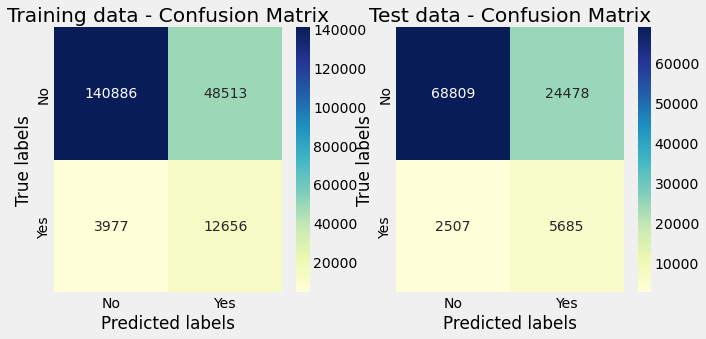

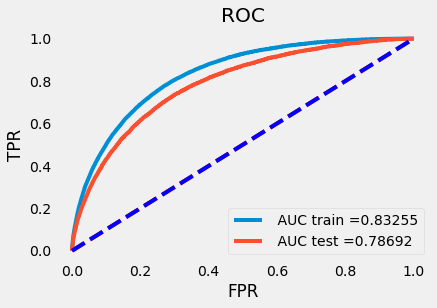

In [14]:
#lgb_model,auc_tr_lgb_model,auc_te_lgb_model = measure_accuracy(study,X_train,X_test,y_train,y_test)
lgb_model,auc_tr_lgb_model,auc_te_lgb_model = measure_accuracy(X_train,X_test,y_train,y_test)

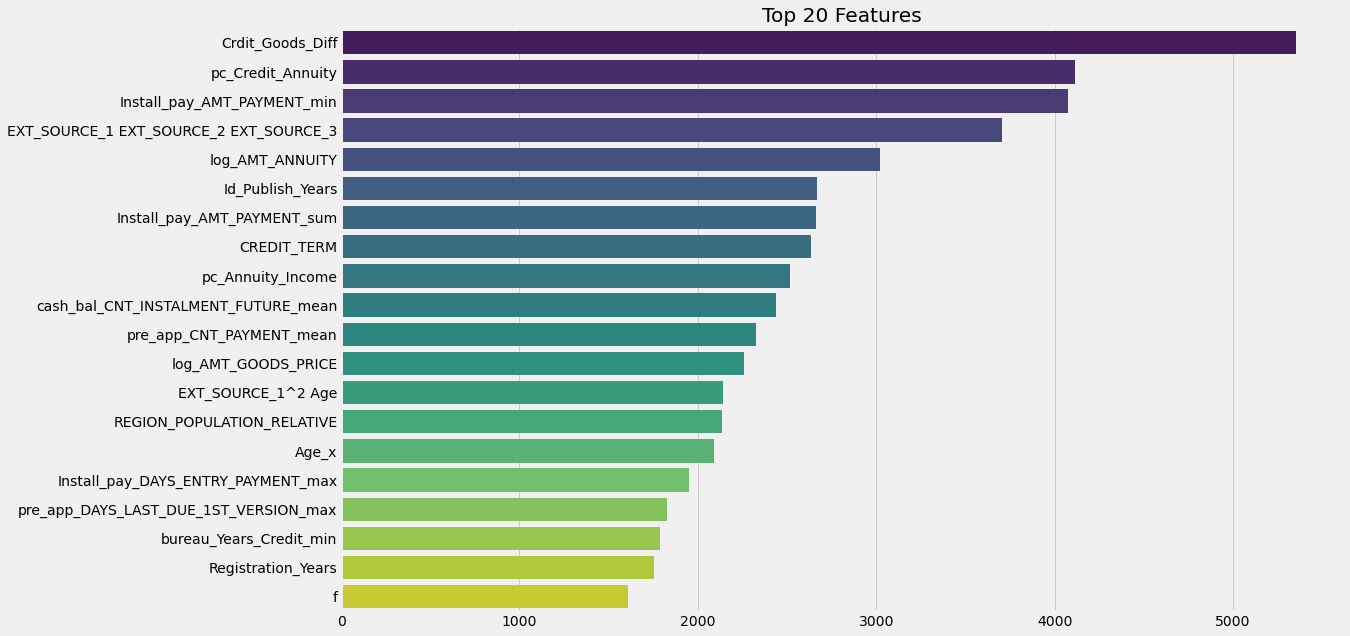

In [15]:
top20_feature_names=[]
feature_importance = lgb_model.feature_importances_
feature_importances = (lgb_model.feature_importances_ / sum(lgb_model.feature_importances_+0.000001)) * 100
indices = feature_importance.argsort()[::-1][:20]
for i in indices:
    top20_feature_names.append(feature_names[i])

#Plot bar plot for top 20 features
plt.close()
column =top20_feature_names
score = feature_importance[indices]
plt.figure(figsize =(16, 10))
sns.barplot(y=column, x=score, palette="viridis")
plt.xticks(rotation=0)
plt.title('Top 20 Features')
plt.show()

In [16]:
# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Feature","Score"]
for val in zip(column,score):
    x.add_row([val[0],val[1]])

x.sortby = "Score"
x.reversesort = True

x.align["Feature"] = "l"
x.align["Score"] = "r"

print(x)

+----------------------------------------+-------+
| Feature                                | Score |
+----------------------------------------+-------+
| Crdit_Goods_Diff                       |  5350 |
| pc_Credit_Annuity                      |  4112 |
| Install_pay_AMT_PAYMENT_min            |  4072 |
| EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3 |  3703 |
| log_AMT_ANNUITY                        |  3019 |
| Id_Publish_Years                       |  2668 |
| Install_pay_AMT_PAYMENT_sum            |  2660 |
| CREDIT_TERM                            |  2632 |
| pc_Annuity_Income                      |  2515 |
| cash_bal_CNT_INSTALMENT_FUTURE_mean    |  2437 |
| pre_app_CNT_PAYMENT_mean               |  2327 |
| log_AMT_GOODS_PRICE                    |  2260 |
| EXT_SOURCE_1^2 Age                     |  2141 |
| REGION_POPULATION_RELATIVE             |  2135 |
| Age_x                                  |  2089 |
| Install_pay_DAYS_ENTRY_PAYMENT_max     |  1950 |
| pre_app_DAYS_LAST_DUE_1ST_VER

In [17]:
import joblib
# save model
joblib.dump(lgb_model, './results/model_lgb.pkl')

['./results/model_lgb.pkl']